## Name: Abhishek Saha
## Roll: 23f1001572  
## Models Included:
- Scratch BiLSTM  
- Roberta-large 
- TF-IDF + SGD Classifier


In [2]:
import numpy as np
import pandas as pd
import torch
import joblib
import lightgbm as lgb
import re, html
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd


DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
TARGET_COLS = ["anger","fear","joy","sadness","surprise"]

TEST_PATH = "/kaggle/input/2025-sep-dl-gen-ai-project/test.csv"
test_df = pd.read_csv(TEST_PATH)

print("Loaded test shape:", test_df.shape)

Loaded test shape: (1707, 2)


## TEXT PREPROCESSING

In [3]:
def preprocess_text(text):
    text = html.unescape(str(text)).lower()
    text = re.sub(r"http\S+|www\.\S+", " ", text)
    text = re.sub(r"@\w+", " ", text)
    text = re.sub(r"[^a-z0-9\s\.\,\!\?\']", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

test_df["clean_text"] = test_df["text"].apply(preprocess_text)

## MODEL 1 — SCRATCH BILSTM ATTENTION

In [4]:
print("\n=== Loading Model 1 (Scratch BiLSTM) ===")

ckpt1 = torch.load(
    "/kaggle/input/abhi-scratch-bilstm/pytorch/default/1/scratch_bilstm.pth",
    map_location=DEVICE,
    weights_only=False
)

vocab = ckpt1["vocab"]
thresholds1 = np.array(ckpt1["best_thresholds"])
sd = ckpt1["model_state_dict"]

emb_shape = sd["embedding.weight"].shape
vocab_size = emb_shape[0]
embedding_dim = emb_shape[1]

# LSTM input shape → hidden_dim extraction
lstm_ih_shape = sd["lstm.weight_ih_l0"].shape  # (4*hidden_dim, embedding_dim)
hidden_dim = lstm_ih_shape[0] // 4

# Detect number of LSTM layers
num_layers = 1
while f"lstm.weight_ih_l{num_layers}" in sd:
    num_layers += 1

dropout = 0.3


max_len = ckpt1.get("max_len", 80)

print("Recovered architecture:")
print(f" vocab_size={vocab_size}")
print(f" embedding_dim={embedding_dim}")
print(f" hidden_dim={hidden_dim}")
print(f" num_layers={num_layers}")
print(f" max_len={max_len}")


def encode(text, max_len=max_len):
    tokens = text.split()
    ids = [vocab.get(w, vocab.get("<unk>", 1)) for w in tokens[:max_len]]
    if len(ids) < max_len:
        ids += [vocab.get("<pad>", 0)] * (max_len - len(ids))
    return ids

test_df["input_ids"] = test_df["clean_text"].apply(lambda x: encode(x))

import torch.nn as nn

class ScratchBiLSTMAttn(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_labels,
                 num_layers=1, dropout=0.4, num_heads=4):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.spatial_dropout = nn.Dropout2d(dropout)

        
        self.lstm = nn.LSTM(
            embed_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True
        )

        
        self.gru = nn.GRU(
            hidden_dim * 2,        
            hidden_dim,            
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )

        
        self.mha = nn.MultiheadAttention(
            embed_dim=hidden_dim * 2, 
            num_heads=num_heads,
            batch_first=True
        )

        
        self.norm1 = nn.LayerNorm(hidden_dim * 2)
        self.norm2 = nn.LayerNorm(hidden_dim * 2)

        self.dropout = nn.Dropout(dropout)

        
        self.fc = nn.Linear(hidden_dim * 4, num_labels)

    def forward(self, input_ids):
        x = self.embedding(input_ids)

        # Spatial dropout
        x = self.spatial_dropout(x.unsqueeze(0)).squeeze(0)

        # LSTM
        out, _ = self.lstm(x)
        out = self.norm1(out)

        # GRU
        out, _ = self.gru(out)
        out = self.norm2(out)

        # Attention
        att_out, _ = self.mha(out, out, out)
        out = out + att_out

        # Pooling
        avg_pool = torch.mean(out, dim=1)        
        max_pool, _ = torch.max(out, dim=1)      

        out = torch.cat([avg_pool, max_pool], dim=1)  

        out = self.dropout(out)
        return self.fc(out)


model1 = ScratchBiLSTMAttn(
    vocab_size=vocab_size,
    embed_dim=embedding_dim,
    hidden_dim=hidden_dim,
    num_labels=len(TARGET_COLS),
    num_layers=num_layers,
    dropout=dropout
)

model1.load_state_dict(sd)
model1.to(DEVICE)
model1.eval()



print("Loaded Model 1 Successfully!")



test_ids = torch.tensor(test_df["input_ids"].tolist(), dtype=torch.long)
test_loader1 = torch.utils.data.DataLoader(test_ids, batch_size=64, shuffle=False)

all_probs1 = []
with torch.no_grad():
    for batch in tqdm(test_loader1):
        batch = batch.to(DEVICE)
        logits = model1(batch)
        probs = torch.sigmoid(logits).cpu().numpy()
        all_probs1.extend(probs)

all_probs1 = np.array(all_probs1)
preds1 = (all_probs1 > thresholds1).astype(int)

sub1 = pd.DataFrame({"id": test_df["id"]})
for i, col in enumerate(TARGET_COLS):
    sub1[col] = preds1[:, i]

sub1.to_csv("submission_model1_bilstm.csv", index=False)

print("Model 1 Done → submission_model1_bilstm.csv")



=== Loading Model 1 (Scratch BiLSTM) ===
Recovered architecture:
 vocab_size=5510
 embedding_dim=128
 hidden_dim=384
 num_layers=2
 max_len=80
Loaded Model 1 Successfully!


100%|██████████| 27/27 [00:33<00:00,  1.25s/it]

Model 1 Done → submission_model1_bilstm.csv


## Model 2 - RoBERTa - Large

In [5]:
print("\n=== Loading Model 2 (Roberta-Large Fine-Tuned) ===")

import torch.nn as nn
from transformers import AutoTokenizer, AutoModel
# Pretrained HuggingFace model files 
PRETRAIN_PATH = "/kaggle/input/pretrain-roberta-abhi/pytorch/default/1/roberta-large"

# Fine-tuned classifier state dict
CKPT_PATH = "/kaggle/input/roberta-large-abhi/pytorch/default/1/best_model.pth"


tokenizer2 = AutoTokenizer.from_pretrained(
    PRETRAIN_PATH,
    local_files_only=True
)


class EmotionClassifier(nn.Module):
    def __init__(self, pretrained_dir, num_labels=5, dropout_rate=0.3):
        super().__init__()
        self.transformer = AutoModel.from_pretrained(
            pretrained_dir,
            local_files_only=True
        )
        hidden = self.transformer.config.hidden_size   # 1024 for roberta-large
        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Linear(hidden, num_labels)

    def forward(self, ids, mask):
        out = self.transformer(input_ids=ids, attention_mask=mask)
        cls = out.last_hidden_state[:, 0]
        return self.classifier(self.dropout(cls))


model2 = EmotionClassifier(PRETRAIN_PATH, num_labels=len(TARGET_COLS))
model2.load_state_dict(torch.load(CKPT_PATH, map_location=DEVICE))
model2.to(DEVICE)
model2.eval()

print("Model 2 Loaded Successfully!")

enc = tokenizer2(
    test_df["clean_text"].tolist(),
    truncation=True,
    padding=True,
    max_length=256,
    return_tensors="pt"
)

test_loader2 = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(enc["input_ids"], enc["attention_mask"]),
    batch_size=32,
    shuffle=False
)

all_probs2 = []

with torch.no_grad():
    for ids, mask in tqdm(test_loader2, desc="Running Model 2"):
        ids, mask = ids.to(DEVICE), mask.to(DEVICE)
        logits = model2(ids, mask)
        probs = torch.sigmoid(logits).cpu().numpy()
        all_probs2.extend(probs)

all_probs2 = np.array(all_probs2)
preds2 = (all_probs2 > 0.5).astype(int)


sub2 = pd.DataFrame({"id": test_df["id"]})
for i, col in enumerate(TARGET_COLS):
    sub2[col] = preds2[:, i]

sub2.to_csv("submission.csv", index=False)
print("Model 2 Done → submission_model2_transformer.csv")



=== Loading Model 2 (Roberta-Large Fine-Tuned) ===


/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

Model 2 Loaded Successfully!


Running Model 2: 100%|██████████| 54/54 [13:24<00:00, 14.90s/it]

Model 2 Done → submission_model2_transformer.csv


## MODEL 3 — TF-IDF + SGD Classifier

In [7]:
print("\n=== Loading Model 3 (TF-IDF + SGDClassifier) ===")

BASE_DIR = "/kaggle/input/tfidf-sdg-abhi/pytorch/default/1"
MODEL3_DIR = f"{BASE_DIR}/model3_outputs"

artifact = joblib.load(f"{MODEL3_DIR}/model3_artifact.pkl")

# Load vectorizers
word_vec_path = f"{BASE_DIR}/{artifact['vectorizers']['word'].lstrip('./')}"
char_vec_path = f"{BASE_DIR}/{artifact['vectorizers']['char'].lstrip('./')}"

tfidf_word = joblib.load(word_vec_path)
tfidf_char = joblib.load(char_vec_path)

# Transform test text
X_test_word = tfidf_word.transform(test_df["clean_text"])
X_test_char = tfidf_char.transform(test_df["clean_text"])

from scipy.sparse import hstack
X_test = hstack([X_test_word, X_test_char])

# Load thresholds
thresholds3 = np.array(artifact["thresholds"])

# 🔥 Load SGD models instead of LightGBM
models3 = {}
for col in TARGET_COLS:
    rel = artifact["models"][col].lstrip("./")
    model_path = f"{BASE_DIR}/{rel}"
    models3[col] = joblib.load(model_path)   # ← FIXED

# 🔥 Predict with SGDClassifier (predict_proba)
test_probs3 = np.zeros((len(test_df), len(TARGET_COLS)))
for i, col in enumerate(TARGET_COLS):
    test_probs3[:, i] = models3[col].predict_proba(X_test)[:, 1]   # ← FIXED

# Thresholding
preds3 = (test_probs3 > thresholds3).astype(int)

# Build submission
sub3 = pd.DataFrame({"id": test_df["id"]})
for i, col in enumerate(TARGET_COLS):
    sub3[col] = preds3[:, i]

sub3.to_csv("submission_model3_tfidf.csv", index=False)
print("Model 3 Done → submission_model3_tfidf.csv")



=== Loading Model 3 (TF-IDF + SGDClassifier) ===
Model 3 Done → submission_model3_tfidf.csv


# Compare the predictions of all 3 models

In [8]:
compare = pd.DataFrame({"id": test_df["id"]})

for col in TARGET_COLS:
    compare[f"{col}_BiLSTM"] = sub1[col]
    compare[f"{col}_RoBERTa"] = sub2[col]
    compare[f"{col}_TFIDF"] = sub3[col]

compare.head(20)

,id,anger_BiLSTM,anger_RoBERTa,anger_TFIDF,fear_BiLSTM,fear_RoBERTa,fear_TFIDF,joy_BiLSTM,joy_RoBERTa,joy_TFIDF,sadness_BiLSTM,sadness_RoBERTa,sadness_TFIDF,surprise_BiLSTM,surprise_RoBERTa,surprise_TFIDF
0,0,1,1,1,1,0,1,0,0,1,0,0,0,0,0,1
1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,2,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0
3,3,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0
4,4,0,0,0,1,1,1,0,0,0,0,0,0,1,1,1
5,5,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
6,6,0,0,0,1,1,1,0,0,0,0,0,0,1,1,1
7,7,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0
8,8,0,0,0,1,1,1,0,0,0,1,1,0,1,0,0
9,9,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0


## Model Agreement Score

In [9]:
agreement = {}

for col in TARGET_COLS:
    m1 = sub1[col].values
    m2 = sub2[col].values
    m3 = sub3[col].values
    
    agree12 = (m1 == m2).mean()
    agree13 = (m1 == m3).mean()
    agree23 = (m2 == m3).mean()
    
    agreement[col] = {
        "BiLSTM vs RoBERTa": round(agree12, 3),
        "BiLSTM vs TFIDF": round(agree13, 3),
        "RoBERTa vs TFIDF": round(agree23, 3),
    }

pd.DataFrame(agreement).T

,BiLSTM vs RoBERTa,BiLSTM vs TFIDF,RoBERTa vs TFIDF
anger,0.871,0.892,0.950
fear,0.729,0.776,0.819
joy,0.829,0.866,0.879
sadness,0.796,0.801,0.843
surprise,0.808,0.846,0.843


### Heatmap — Model Agreement Scores

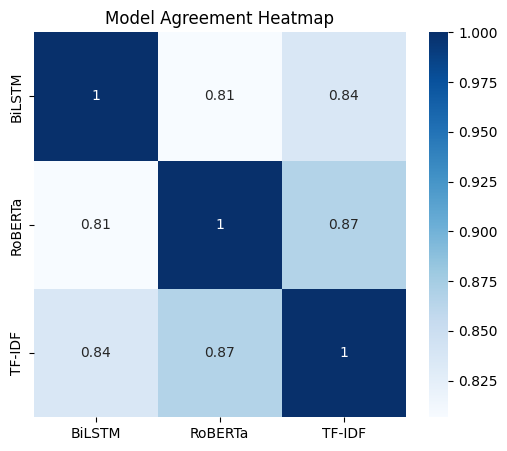

In [10]:
agreement_matrix = np.zeros((3,3))
models = ["BiLSTM", "RoBERTa", "TF-IDF"]

all_preds = {
    "BiLSTM": sub1[TARGET_COLS].values,
    "RoBERTa": sub2[TARGET_COLS].values,
    "TF-IDF": sub3[TARGET_COLS].values
}

# Compute pairwise agreement
for i, m1 in enumerate(models):
    for j, m2 in enumerate(models):
        agreement_matrix[i][j] = (all_preds[m1] == all_preds[m2]).mean()

# Plot heatmap
plt.figure(figsize=(6,5))
sns.heatmap(agreement_matrix, annot=True, cmap="Blues", xticklabels=models, yticklabels=models)
plt.title("Model Agreement Heatmap")
plt.show()


## Per-Label Positive Rate

In [12]:
positive_rate = {}

for col in TARGET_COLS:
    positive_rate[col] = {
        "BiLSTM %": round(sub1[col].mean()*100, 2),
        "RoBERTa %": round(sub2[col].mean()*100, 2),
        "TF-IDF %": round(sub3[col].mean()*100, 2)
    }

pd.DataFrame(positive_rate).T


,BiLSTM %,RoBERTa %,TF-IDF %
anger,16.52,11.01,7.62
fear,63.27,53.60,60.22
joy,18.80,25.72,19.98
sadness,25.07,30.76,31.81
surprise,31.22,27.53,31.75


### Bar Plot — Positive Prediction Rate Comparison

<Figure size 1000x600 with 0 Axes>

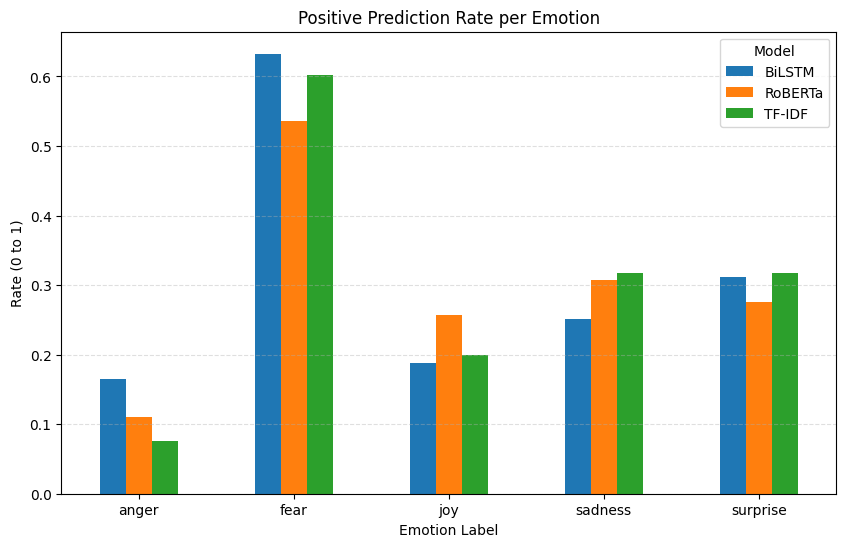

In [13]:
positive_rate = {}

for col in TARGET_COLS:
    positive_rate[col] = {
        "BiLSTM": sub1[col].mean(),
        "RoBERTa": sub2[col].mean(),
        "TF-IDF": sub3[col].mean()
    }

pos_df = pd.DataFrame(positive_rate).T

# Plot
plt.figure(figsize=(10,6))
pos_df.plot(kind="bar", figsize=(10,6))
plt.title("Positive Prediction Rate per Emotion")
plt.ylabel("Rate (0 to 1)")
plt.xlabel("Emotion Label")
plt.xticks(rotation=0)
plt.legend(title="Model")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.show()


### Emotion-Wise Agreement Heatmap

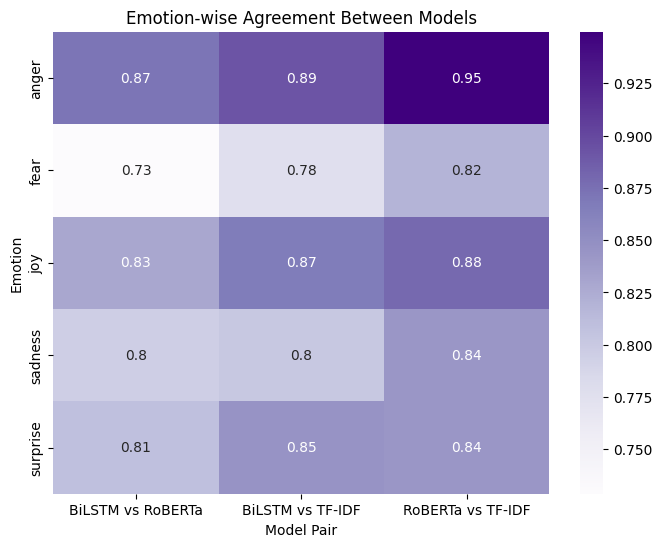

In [14]:
label_agreement = {}

for col in TARGET_COLS:
    m1, m2, m3 = sub1[col], sub2[col], sub3[col]

    label_agreement[col] = [
        (m1 == m2).mean(),
        (m1 == m3).mean(),
        (m2 == m3).mean()
    ]

label_df = pd.DataFrame(label_agreement, index=["BiLSTM vs RoBERTa", "BiLSTM vs TF-IDF", "RoBERTa vs TF-IDF"]).T

plt.figure(figsize=(8,6))
sns.heatmap(label_df, annot=True, cmap="Purples")
plt.title("Emotion-wise Agreement Between Models")
plt.xlabel("Model Pair")
plt.ylabel("Emotion")
plt.show()
